<a href="https://colab.research.google.com/github/jjefferson2006/DSWP_JJ_altera/blob/main/desafio_analise5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycaret

     |████████████████████████████████| 256kB 2.7MB/s 
     |████████████████████████████████| 148.9MB 74kB/s 
     |████████████████████████████████| 266kB 28.0MB/s 
     |████████████████████████████████| 66.2MB 157kB/s 
     |████████████████████████████████| 1.8MB 38.0MB/s 
     |████████████████████████████████| 276kB 46.0MB/s 
     |████████████████████████████████| 6.8MB 37.4MB/s 
     |████████████████████████████████| 174kB 50.2MB/s 
     |████████████████████████████████| 102kB 10.7MB/s 
     |████████████████████████████████| 13.9MB 41.5MB/s 
     |████████████████████████████████| 1.6MB 30.5MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 3.1MB 36.8MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 604kB 40.6MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 2.1MB 38.8MB/s 
     |████████████████████████████████| 153kB 43.6MB/s

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from pycaret.classification import *

In [4]:
url = 'https://raw.githubusercontent.com/jjefferson2006/DSWP_JJ_altera/main/train.csv'
df_churn_train = pd.read_csv(url)
df_churn_train

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,6684,Male,0,No,No,43.0,No,No phone service,DSL,No,No,Yes,Yes,No,Yes,One year,No,Electronic check,44.15,1931.3,0
5630,604,Male,0,No,No,NaN,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,No,Electronic check,108.65,4903.2,0
5631,4803,Female,0,No,No,28.0,Yes,No,DSL,No,Yes,No,Yes,No,No,Month-to-month,No,Bank transfer (automatic),54.65,1517.5,0
5632,6317,Male,0,Yes,Yes,63.0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.25,1573.05,0


In [5]:
#Normalizar as colunas
df_churn_train.columns = [col.lower() for col in df_churn_train.columns]
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [6]:
df_churn_train.dtypes

id                    int64
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure              float64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                 int64
dtype: object

In [7]:
df_churn_train.isna().sum()

id                    0
gender                0
seniorcitizen         0
partner               0
dependents          218
tenure              461
phoneservice          0
multiplelines         0
internetservice       0
onlinesecurity        0
onlinebackup          0
deviceprotection      0
techsupport           0
streamingtv           0
streamingmovies       0
contract              0
paperlessbilling      0
paymentmethod        99
monthlycharges        0
totalcharges          0
churn                 0
dtype: int64

In [8]:
df_churn_train.shape

(5634, 21)

###pay

In [9]:
#contar a variavel 
df_churn_train['paymentmethod'].value_counts()

Electronic check             1887
Mailed check                 1272
Bank transfer (automatic)    1212
Credit card (automatic)      1164
Name: paymentmethod, dtype: int64

In [10]:
df_churn_train['paymentmethod'].isna().sum()

99

In [11]:
df_churn_train['paymentmethod'].fillna('Credit card (automatic)', inplace=True)

###trat dep

In [12]:
df_churn_train['dependents'].isna().sum()

218

In [13]:
#contar a variavel 
df_churn_train['dependents'].value_counts()

No     3793
Yes    1623
Name: dependents, dtype: int64

In [14]:
#criterio = moda
df_churn_train['dependents'].fillna('Yes', inplace=True)

###tratar as numeric

In [15]:
df_churn_train['totalcharges'] = df_churn_train['totalcharges'].str.replace(',', '.')
df_churn_train['totalcharges'] = pd.to_numeric(df_churn_train['totalcharges'], errors= 'coerce')



In [16]:
df_churn_train['monthlycharges'].isna().sum()

0

In [17]:
df_churn_train['totalcharges'].sum()

12790788.7

In [18]:
df_churn_train['tenure'].isna().sum()

461

In [19]:
df_churn_train['tenure_esti']=round(df_churn_train['totalcharges']/df_churn_train['monthlycharges'],2)

In [20]:
df_churn_train['tenure_rou']=round(df_churn_train['tenure_esti'])

In [21]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,tenure_esti,tenure_rou
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),45.05,2560.10,0,56.83,57.0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0,16.93,17.0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70,0,59.93,60.0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1,34.79,35.0
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80,1,27.91,28.0


In [22]:
l_tot_ten = list(df_churn_train[df_churn_train['tenure'].isna()].index)
l_tot_ten

[1,
 11,
 34,
 45,
 55,
 92,
 94,
 109,
 121,
 133,
 185,
 190,
 193,
 200,
 221,
 223,
 231,
 234,
 247,
 251,
 268,
 288,
 298,
 323,
 332,
 346,
 353,
 368,
 372,
 381,
 390,
 398,
 408,
 409,
 436,
 453,
 463,
 464,
 465,
 469,
 472,
 474,
 483,
 485,
 486,
 508,
 520,
 544,
 559,
 560,
 572,
 596,
 602,
 620,
 632,
 640,
 682,
 700,
 707,
 773,
 787,
 791,
 809,
 811,
 830,
 832,
 851,
 854,
 880,
 886,
 923,
 925,
 950,
 956,
 958,
 968,
 988,
 992,
 1003,
 1049,
 1070,
 1090,
 1098,
 1105,
 1114,
 1115,
 1127,
 1135,
 1137,
 1143,
 1159,
 1169,
 1173,
 1192,
 1196,
 1206,
 1208,
 1214,
 1233,
 1238,
 1254,
 1261,
 1265,
 1266,
 1278,
 1279,
 1286,
 1336,
 1373,
 1405,
 1406,
 1414,
 1420,
 1440,
 1449,
 1475,
 1476,
 1490,
 1501,
 1503,
 1516,
 1526,
 1563,
 1584,
 1587,
 1591,
 1614,
 1637,
 1655,
 1681,
 1691,
 1695,
 1696,
 1703,
 1716,
 1718,
 1725,
 1734,
 1742,
 1750,
 1753,
 1770,
 1778,
 1789,
 1793,
 1802,
 1813,
 1817,
 1830,
 1845,
 1872,
 1887,
 1896,
 1906,
 1922,
 

In [23]:
for i in l_tot_ten:
    df_churn_train['tenure'][i] = df_churn_train['tenure_rou'][i]


In [24]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,tenure_esti,tenure_rou
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),45.05,2560.10,0,56.83,57.0
1,6731,Male,0,Yes,Yes,17.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0,16.93,17.0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70,0,59.93,60.0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1,34.79,35.0
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80,1,27.91,28.0


In [25]:
df_churn_train.drop(columns=['tenure_esti','tenure_rou'], inplace=True)

In [26]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,Female,0,No,No,56.0,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,Credit card (automatic),45.05,2560.10,0
1,6731,Male,0,Yes,Yes,17.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70,0
3,6861,Female,0,No,No,37.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80,1


###trata categor

In [27]:
df_churn_train.gender.replace(['Female', 'Male'], [1, 0], inplace=True)
df_churn_train.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_train.phoneservice.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_train.paperlessbilling.replace(['Yes', 'No'], [1, 0], inplace=True)

In [28]:
df_churn_train.internetservice.replace(['Fiber optic', 'DSL', 'No'], [1,2,0], inplace=True)
df_churn_train.paymentmethod.replace(['Electronic check', 'Bank transfer (automatic)', 'Mailed check', 'Credit card (automatic)'], [1,2,3,4], inplace=True)
df_churn_train.contract.replace(['Two year', 'One year', 'Month-to-month'], [0,1,2], inplace=True)
df_churn_train.multiplelines.replace(['No', 'Yes', 'No phone service'], [0,1,3], inplace=True)
df_churn_train.onlinesecurity.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True) 
df_churn_train.onlinebackup.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_train.deviceprotection.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_train.techsupport.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_train.streamingtv.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_train.streamingmovies.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True) 

In [29]:
df_churn_train.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)

In [30]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,1,0,0,0,56.0,0,3,2,1,1,1,1,0,0,0,0,4,45.05,2560.10,0
1,6731,0,0,1,1,17.0,1,0,0,2,2,2,2,2,2,1,0,3,19.65,332.65,0
2,6479,1,0,1,0,60.0,1,1,1,0,1,1,1,1,1,0,1,4,110.80,6640.70,0
3,6861,1,0,0,0,37.0,1,1,1,0,1,1,0,1,1,2,1,2,101.90,3545.35,1
4,3266,0,0,1,1,29.0,1,0,1,0,0,0,0,0,0,2,1,1,70.75,1974.80,1


In [31]:
df_churn_train.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        8
churn               0
dtype: int64

In [32]:
l_index_charg = list(df_churn_train[df_churn_train['totalcharges'].isna()].index)
l_index_charg

[161, 416, 1766, 2145, 3375, 3404, 4008, 5151]

In [33]:
df_churn_train.iloc[5151:5153]

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
5151,1341,1,0,1,1,0.0,0,3,2,1,1,1,1,1,0,0,0,4,56.05,NaN,0
5152,3749,0,0,0,0,48.0,1,0,2,0,1,1,1,1,1,0,0,4,78.90,3771.5,0


In [34]:
for i in l_index_charg:
    df_churn_train['totalcharges'][i] = 0.0

In [35]:
df_churn_train.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [36]:
df_churn_train.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,4030,1,0,0,0,56.0,0,3,2,1,1,1,1,0,0,0,0,4,45.05,2560.10,0
1,6731,0,0,1,1,17.0,1,0,0,2,2,2,2,2,2,1,0,3,19.65,332.65,0
2,6479,1,0,1,0,60.0,1,1,1,0,1,1,1,1,1,0,1,4,110.80,6640.70,0
3,6861,1,0,0,0,37.0,1,1,1,0,1,1,0,1,1,2,1,2,101.90,3545.35,1
4,3266,0,0,1,1,29.0,1,0,1,0,0,0,0,0,0,2,1,1,70.75,1974.80,1


In [37]:
from sklearn import feature_selection # Library para seleção de features

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
df_corr = df_churn_train.copy()

In [170]:
# calcula a correlação entre as colunas/variáveis do dataframe
correlacao = df_corr.corr().abs()

# Seleciona o triângulo superior da matriz de correlação
correlacao = correlacao.where(np.triu(np.ones(correlacao.shape), k = 1).astype(np.bool))
correlacao

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
id,NaN,0.005947,0.005344,0.001929,0.002239,0.002524,0.024654,0.019656,0.013340,0.007640,0.001144,0.012485,0.006038,0.005187,0.016632,0.009322,0.002960,0.000462,0.013354,0.003117,0.015188
gender,NaN,NaN,0.002990,0.007471,0.008359,0.008574,0.001033,0.000008,0.004472,0.013724,0.012206,0.000850,0.004716,0.004294,0.004361,0.005028,0.005634,0.010922,0.003511,0.005655,0.000797
seniorcitizen,NaN,NaN,NaN,0.018942,0.197955,0.007509,0.009136,0.067751,0.035025,0.211735,0.157197,0.163074,0.223671,0.128453,0.122026,0.146374,0.155394,0.130077,0.215351,0.093825,0.161488
partner,NaN,NaN,NaN,NaN,0.424996,0.386215,0.024696,0.053151,0.002202,0.084042,0.084194,0.092959,0.072545,0.084551,0.076027,0.304246,0.033213,0.055891,0.096741,0.319301,0.164049
dependents,NaN,NaN,NaN,NaN,NaN,0.146342,0.009388,0.025156,0.031273,0.169746,0.135362,0.131754,0.163162,0.120999,0.106257,0.225672,0.105519,0.104699,0.096580,0.057217,0.147005
tenure,NaN,NaN,NaN,NaN,NaN,NaN,0.013955,0.170159,0.028083,0.151206,0.177515,0.184937,0.148388,0.142923,0.147405,0.672333,0.006489,0.165075,0.244726,0.825807,0.358069
phoneservice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.845965,0.387146,0.123977,0.150134,0.143173,0.124538,0.175616,0.167493,0.006371,0.023651,0.004002,0.248876,0.116320,0.019574
multiplelines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.379822,0.214000,0.204830,0.195676,0.214463,0.206797,0.199850,0.055223,0.065518,0.033667,0.020536,0.142393,0.001981
internetservice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.603406,0.656597,0.661955,0.610719,0.713739,0.708944,0.092882,0.140747,0.072912,0.325458,0.177609,0.041798
onlinesecurity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.747169,0.746846,0.791255,0.700284,0.703560,0.388265,0.336868,0.299409,0.623441,0.152117,0.342879


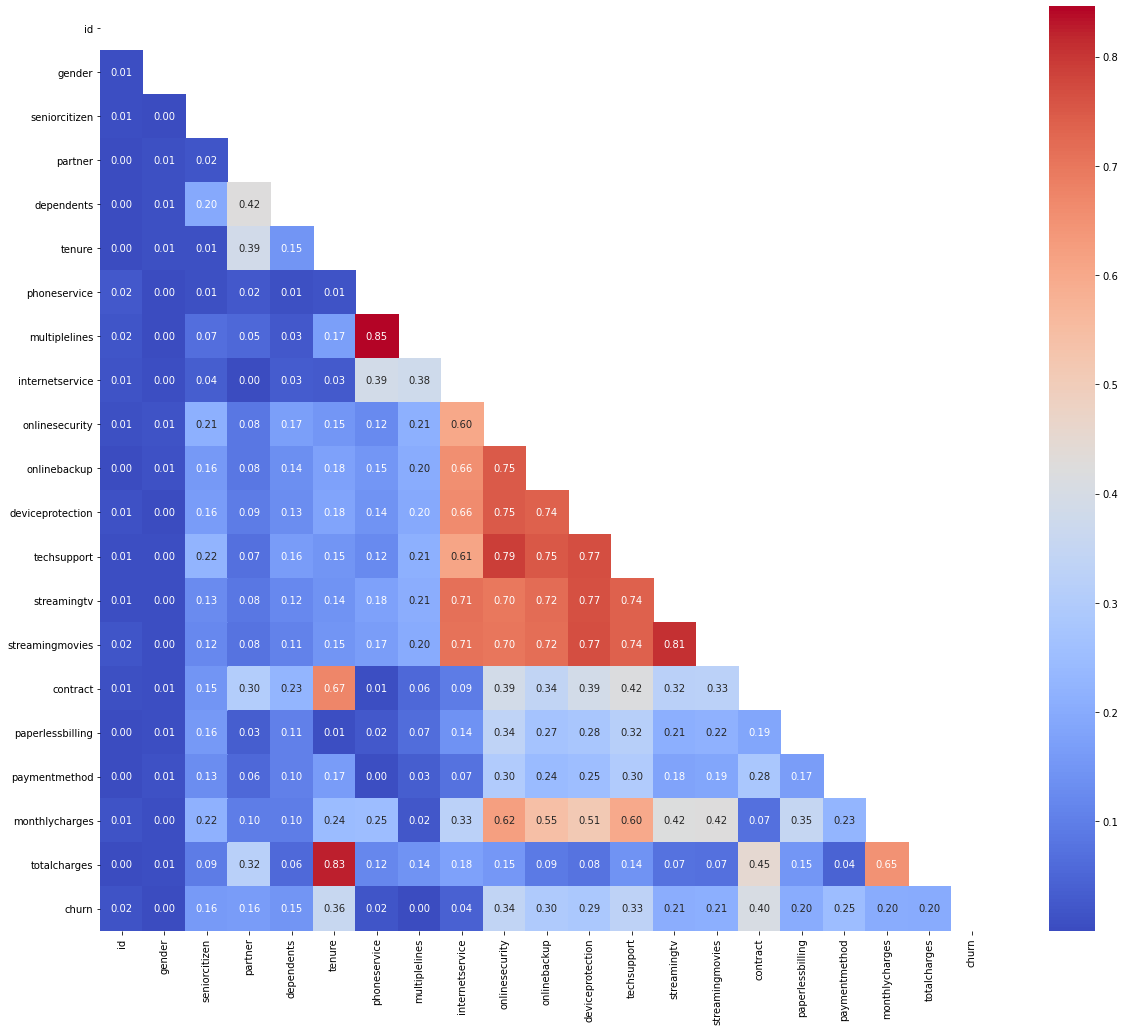

In [171]:
fig, ax = plt.subplots(figsize = (20, 17)) 
mask = np.zeros_like(df_corr.corr().abs())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(df_corr.corr().abs(), mask = mask, ax = ax, cmap ='coolwarm', annot = True, fmt = '.2f')

In [172]:
set_variaveis_corr = set()
matrix_corr = df_corr.corr()
matrix_corr

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
id,1.000000,0.005947,-0.005344,0.001929,0.002239,0.002524,-0.024654,0.019656,0.013340,-0.007640,0.001144,-0.012485,0.006038,-0.005187,-0.016632,-0.009322,-0.002960,-0.000462,-0.013354,-0.003117,0.015188
gender,0.005947,1.000000,0.002990,0.007471,-0.008359,-0.008574,0.001033,-0.000008,-0.004472,0.013724,0.012206,0.000850,0.004716,0.004294,0.004361,0.005028,0.005634,-0.010922,0.003511,-0.005655,0.000797
seniorcitizen,-0.005344,0.002990,1.000000,0.018942,-0.197955,0.007509,0.009136,0.067751,0.035025,-0.211735,-0.157197,-0.163074,-0.223671,-0.128453,-0.122026,0.146374,0.155394,-0.130077,0.215351,0.093825,0.161488
partner,0.001929,0.007471,0.018942,1.000000,0.424996,0.386215,0.024696,0.053151,0.002202,0.084042,0.084194,0.092959,0.072545,0.084551,0.076027,-0.304246,-0.033213,0.055891,0.096741,0.319301,-0.164049
dependents,0.002239,-0.008359,-0.197955,0.424996,1.000000,0.146342,0.009388,-0.025156,-0.031273,0.169746,0.135362,0.131754,0.163162,0.120999,0.106257,-0.225672,-0.105519,0.104699,-0.096580,0.057217,-0.147005
tenure,0.002524,-0.008574,0.007509,0.386215,0.146342,1.000000,0.013955,0.170159,0.028083,0.151206,0.177515,0.184937,0.148388,0.142923,0.147405,-0.672333,-0.006489,0.165075,0.244726,0.825807,-0.358069
phoneservice,-0.024654,0.001033,0.009136,0.024696,0.009388,0.013955,1.000000,-0.845965,-0.387146,0.123977,0.150134,0.143173,0.124538,0.175616,0.167493,-0.006371,0.023651,-0.004002,0.248876,0.116320,0.019574
multiplelines,0.019656,-0.000008,0.067751,0.053151,-0.025156,0.170159,-0.845965,1.000000,0.379822,-0.214000,-0.204830,-0.195676,-0.214463,-0.206797,-0.199850,-0.055223,0.065518,-0.033667,0.020536,0.142393,0.001981
internetservice,0.013340,-0.004472,0.035025,0.002202,-0.031273,0.028083,-0.387146,0.379822,1.000000,-0.603406,-0.656597,-0.661955,-0.610719,-0.713739,-0.708944,0.092882,0.140747,-0.072912,0.325458,0.177609,0.041798
onlinesecurity,-0.007640,0.013724,-0.211735,0.084042,0.169746,0.151206,0.123977,-0.214000,-0.603406,1.000000,0.747169,0.746846,0.791255,0.700284,0.703560,-0.388265,-0.336868,0.299409,-0.623441,-0.152117,-0.342879


In [173]:
for i in range(len(matrix_corr.columns)):
    for j in range(i):
        if abs(matrix_corr.iloc[i, j]) > 0.7:
            colname = matrix_corr.columns[i]
            set_variaveis_corr.add(colname)

set_variaveis_corr

{'deviceprotection',
 'multiplelines',
 'onlinebackup',
 'streamingmovies',
 'streamingtv',
 'techsupport',
 'totalcharges'}

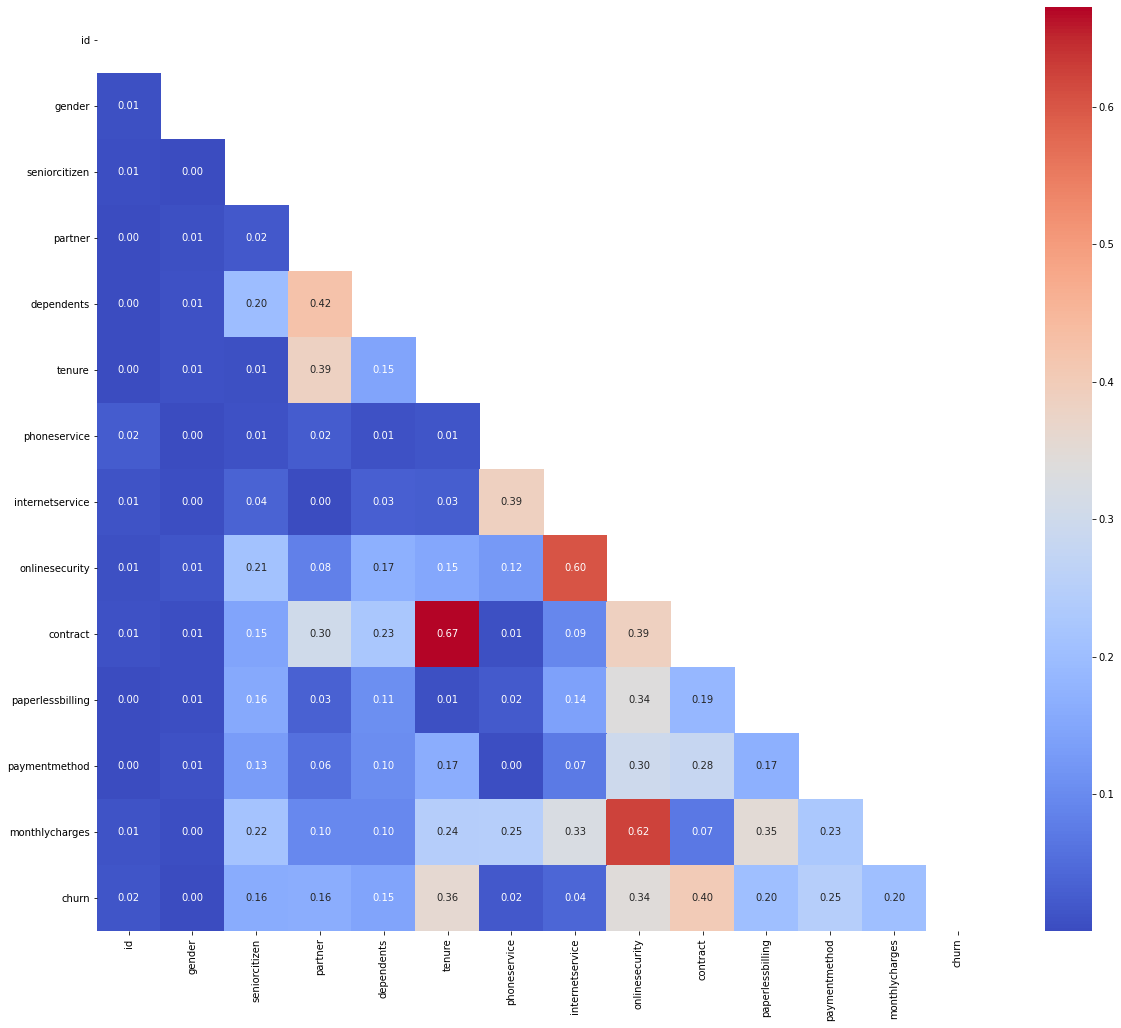

In [174]:
df_corr = df_corr.drop(set_variaveis_corr, axis = 1)

fig, ax = plt.subplots(figsize = (20, 17)) 
mask = np.zeros_like(df_corr.corr().abs())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(df_corr.corr().abs(), mask = mask, ax = ax, cmap='coolwarm', annot = True, fmt = '.2f')

In [175]:
df_corr.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,internetservice,onlinesecurity,contract,paperlessbilling,paymentmethod,monthlycharges,churn
0,4030,1,0,0,0,56.0,0,2,1,0,0,4,45.05,0
1,6731,0,0,1,1,17.0,1,0,2,1,0,3,19.65,0
2,6479,1,0,1,0,60.0,1,1,0,0,1,4,110.80,0
3,6861,1,0,0,0,37.0,1,1,0,2,1,2,101.90,1
4,3266,0,0,1,1,29.0,1,1,0,2,1,1,70.75,1


In [176]:
df_corr_treino = df_corr.copy()

#####tratar test

In [100]:
url = 'https://raw.githubusercontent.com/jjefferson2006/DSWP_JJ_altera/main/test.csv'
df_churn_test = pd.read_csv(url)
df_churn_test

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,5027,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.3
1,1733,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,NaN,99.00,5969.3
2,5384,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,6554,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,364,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,4897,Male,0,No,NaN,24.0,Yes,No,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,49.70,1167.8
1405,6940,Male,0,No,No,35.0,Yes,No,Fiber optic,Yes,No,No,Yes,No,Yes,One year,Yes,Electronic check,89.20,3251.3
1406,804,Female,0,Yes,No,46.0,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Two year,Yes,Credit card (automatic),64.20,3009.5
1407,1143,Male,1,Yes,Yes,11.0,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),75.20,775.3


In [101]:
#Normalizar as colunas
df_churn_test.columns = [col.lower() for col in df_churn_test.columns]
df_churn_test.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,5027,Male,0,Yes,Yes,23.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),20.00,445.3
1,1733,Male,1,Yes,Yes,61.0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,One year,No,NaN,99.00,5969.3
2,5384,Male,0,No,No,36.0,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,84.75,3050.15
3,6554,Female,0,Yes,Yes,61.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),61.45,3751.15
4,364,Female,0,No,No,47.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,20.55,945.7


In [102]:
df_churn_test['dependents'].fillna('Yes', inplace=True)

In [103]:
df_churn_test['paymentmethod'].fillna('Credit card (automatic)', inplace=True)

In [104]:
df_churn_test['totalcharges'] = df_churn_test['totalcharges'].str.replace(',', '.')
df_churn_test['totalcharges'] = pd.to_numeric(df_churn_test['totalcharges'], errors= 'coerce')

In [105]:
df_churn_test[['totalcharges']].isna().sum()

totalcharges    3
dtype: int64

In [106]:
df_churn_test['tenure'].isna().sum()

118

In [ ]:
#atenção

In [107]:
df_churn_test['tenure_esti']=round(df_churn_test['totalcharges']/df_churn_train['monthlycharges'],2)

In [108]:
df_churn_test['tenure_rou']=round(df_churn_test['tenure_esti'])

In [109]:
l_tot_ten = list(df_churn_test[df_churn_test['tenure'].isna()].index)
l_tot_ten

[8,
 15,
 32,
 38,
 41,
 54,
 69,
 82,
 113,
 117,
 118,
 125,
 149,
 172,
 173,
 185,
 193,
 213,
 238,
 246,
 268,
 277,
 287,
 295,
 318,
 324,
 339,
 351,
 355,
 363,
 377,
 417,
 467,
 476,
 483,
 487,
 495,
 498,
 511,
 513,
 516,
 517,
 518,
 561,
 562,
 563,
 573,
 599,
 624,
 629,
 635,
 638,
 641,
 654,
 660,
 662,
 669,
 677,
 678,
 728,
 729,
 734,
 740,
 747,
 764,
 765,
 791,
 796,
 805,
 817,
 820,
 827,
 835,
 842,
 861,
 888,
 897,
 910,
 912,
 918,
 925,
 926,
 928,
 952,
 953,
 958,
 973,
 979,
 987,
 1009,
 1012,
 1022,
 1034,
 1045,
 1051,
 1069,
 1107,
 1159,
 1163,
 1169,
 1173,
 1189,
 1200,
 1213,
 1222,
 1224,
 1254,
 1276,
 1303,
 1310,
 1325,
 1344,
 1367,
 1368,
 1385,
 1387,
 1389,
 1394]

In [110]:
for i in l_tot_ten:
    df_churn_test['tenure'][i] = df_churn_test['tenure_rou'][i]


In [111]:
df_churn_test.drop(columns=['tenure_esti','tenure_rou'], inplace=True)

In [112]:
l_index_charg = list(df_churn_test[df_churn_test['totalcharges'].isna()].index)
l_index_charg

[313, 1063, 1297]

In [113]:
df_churn_test[['tenure','totalcharges']][313:314]

,tenure,totalcharges
313,0.0,NaN


In [114]:
for i in l_index_charg:
    df_churn_test['totalcharges'][i] = 0.0

In [115]:
df_churn_test.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

In [116]:
df_churn_test['totalcharges'][313]

0.0

In [117]:
df_churn_test.gender.replace(['Female', 'Male'], [1, 0], inplace=True)
df_churn_test.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_test.phoneservice.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_test.paperlessbilling.replace(['Yes', 'No'], [1, 0], inplace=True)

In [118]:
df_churn_test.internetservice.replace(['Fiber optic', 'DSL', 'No'], [1,2,0], inplace=True)
df_churn_test.paymentmethod.replace(['Electronic check', 'Bank transfer (automatic)', 'Mailed check', 'Credit card (automatic)'], [1,2,3,4], inplace=True)
df_churn_test.contract.replace(['Two year', 'One year', 'Month-to-month'], [0,1,2], inplace=True)
df_churn_test.multiplelines.replace(['No', 'Yes', 'No phone service'], [0,1,3], inplace=True)
df_churn_test.onlinesecurity.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True) 
df_churn_test.onlinebackup.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_test.deviceprotection.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_test.techsupport.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_test.streamingtv.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True)
df_churn_test.streamingmovies.replace(['No', 'Yes', 'No internet service'], [0,1,2], inplace=True) 


In [119]:
df_churn_test.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)

In [120]:
df_churn_test.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

In [121]:
l_index_charg1 = list(df_churn_test[df_churn_test['totalcharges'].isna()].index)
l_index_charg1

[]

In [122]:
df_churn_test.iloc[313:314]

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
313,4381,1,0,1,1,0.0,1,0,0,2,2,2,2,2,2,0,0,3,20.0,0.0


In [123]:
df_churn_test.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,5027,0,0,1,1,23.0,1,0,0,2,2,2,2,2,2,1,1,4,20.00,445.30
1,1733,0,1,1,1,61.0,1,1,1,0,1,0,0,1,1,1,0,4,99.00,5969.30
2,5384,0,0,0,0,36.0,1,1,1,0,0,0,0,0,1,2,1,1,84.75,3050.15
3,6554,1,0,1,1,61.0,0,3,2,0,1,1,1,1,1,0,1,2,61.45,3751.15
4,364,1,0,0,0,47.0,1,0,0,2,2,2,2,2,2,0,1,3,20.55,945.70


In [125]:
df_churn_test.drop(columns = ['multiplelines', 'streamingmovies', 'totalcharges'], inplace = True)

In [126]:
df_churn_test.head()

,id,gender,seniorcitizen,partner,dependents,tenure,phoneservice,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,contract,paperlessbilling,paymentmethod,monthlycharges
0,5027,0,0,1,1,23.0,1,0,2,2,2,2,2,1,1,4,20.00
1,1733,0,1,1,1,61.0,1,1,0,1,0,0,1,1,0,4,99.00
2,5384,0,0,0,0,36.0,1,1,0,0,0,0,0,2,1,1,84.75
3,6554,1,0,1,1,61.0,0,2,0,1,1,1,1,0,1,2,61.45
4,364,1,0,0,0,47.0,1,0,2,2,2,2,2,0,1,3,20.55


In [139]:
df_churn_test.drop(columns = ['deviceprotection', 'onlinebackup', 'streamingtv', 'techsupport'], inplace = True)

In [178]:
df_churn_test.drop(columns=['gender','paperlessbilling' ], inplace = True)

In [200]:
df_churn_test.drop(columns=['phoneservice','dependents' ], inplace = True)

In [201]:
df_churn_test

,id,seniorcitizen,partner,tenure,internetservice,onlinesecurity,contract,paymentmethod,monthlycharges
0,5027,0,1,23.0,0,2,1,4,20.00
1,1733,1,1,61.0,1,0,1,4,99.00
2,5384,0,0,36.0,1,0,2,1,84.75
3,6554,0,1,61.0,2,0,0,2,61.45
4,364,0,0,47.0,0,2,0,3,20.55
...,...,...,...,...,...,...,...,...,...
1404,4897,0,0,24.0,2,0,2,3,49.70
1405,6940,0,0,35.0,1,1,1,1,89.20
1406,804,0,1,46.0,2,0,0,4,64.20
1407,1143,1,1,11.0,1,0,2,4,75.20


###drop no treino

In [180]:
df_corr_treino.drop(columns=['gender','paperlessbilling' ], inplace = True)

In [204]:
df_corr_treino.drop(columns=['phoneservice','dependents' ], inplace = True)

KeyError: ignored

In [205]:
df_corr_treino

,id,seniorcitizen,partner,tenure,internetservice,onlinesecurity,contract,paymentmethod,monthlycharges,churn
0,4030,0,0,56.0,2,1,0,4,45.05,0
1,6731,0,1,17.0,0,2,1,3,19.65,0
2,6479,0,1,60.0,1,0,0,4,110.80,0
3,6861,0,0,37.0,1,0,2,2,101.90,1
4,3266,0,1,29.0,1,0,2,1,70.75,1
...,...,...,...,...,...,...,...,...,...,...
5629,6684,0,0,43.0,2,0,1,1,44.15,0
5630,604,0,0,45.0,1,0,0,1,108.65,0
5631,4803,0,0,28.0,2,0,2,2,54.65,0
5632,6317,0,1,63.0,0,2,0,3,25.25,0


###automl

In [206]:
clf = setup(data = df_corr_treino,
            target = 'churn',
            #numeric_features = ['tenure', 'monthlycharges', 'totalcharges'] 
            #numeric_imputation = 'mean'
            categorical_features = ['seniorcitizen', 'partner', 'internetservice', 'onlinesecurity',
            'contract', 'paymentmethod'], # lista das variáveis categóricas
            ignore_features = ['id'], 
            silent = False)

,Description,Value
0,session_id,3607
1,Target,churn
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5634, 10)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [207]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8037,0.8514,0.5552,0.6538,0.5984,0.4700,0.4741,0.185
gbc,Gradient Boosting Classifier,0.8017,0.8515,0.5225,0.6607,0.5806,0.4536,0.4607,0.330
catboost,CatBoost Classifier,0.8002,0.8443,0.5302,0.6537,0.5832,0.4540,0.4597,2.678
lr,Logistic Regression,0.7984,0.8484,0.5341,0.6472,0.5828,0.4518,0.4570,0.164
lightgbm,Light Gradient Boosting Machine,0.7984,0.8360,0.5341,0.6468,0.5831,0.4520,0.4568,0.186
ridge,Ridge Classifier,0.7974,0.0000,0.4976,0.6572,0.5640,0.4356,0.4441,0.020
lda,Linear Discriminant Analysis,0.7974,0.8458,0.5629,0.6334,0.5944,0.4602,0.4627,0.031
xgboost,Extreme Gradient Boosting,0.7847,0.8251,0.5139,0.6133,0.5571,0.4167,0.4209,0.671
knn,K Neighbors Classifier,0.7776,0.7869,0.5004,0.5971,0.5428,0.3976,0.4014,0.127
rf,Random Forest Classifier,0.7720,0.8020,0.4745,0.5867,0.5232,0.3759,0.3804,0.669


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=3607)

In [194]:
lr = create_model('lr') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8177,0.8501,0.5714,0.6897,0.6250,0.5060,0.5099
1,0.8152,0.8590,0.5048,0.7162,0.5922,0.4773,0.4895
2,0.7797,0.8368,0.4952,0.6047,0.5445,0.4012,0.4046
3,0.7995,0.8371,0.5481,0.6404,0.5907,0.4590,0.4614
4,0.8020,0.8381,0.5673,0.6413,0.6020,0.4709,0.4725
5,0.8020,0.8480,0.5385,0.6512,0.5895,0.4606,0.4642
6,0.8376,0.8723,0.5385,0.7778,0.6364,0.5362,0.5512
7,0.8046,0.8583,0.5769,0.6452,0.6091,0.4794,0.4807
8,0.7868,0.8476,0.5238,0.6180,0.5670,0.4269,0.4294
9,0.7944,0.8542,0.6000,0.6176,0.6087,0.4693,0.4694


In [208]:
ada = create_model('ada')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8025,0.8462,0.5385,0.6512,0.5895,0.4610,0.4646
1,0.8076,0.8728,0.6250,0.6373,0.6311,0.5009,0.5010
2,0.7975,0.8412,0.5619,0.6344,0.5960,0.4615,0.4630
3,0.8122,0.8720,0.5096,0.6974,0.5889,0.4710,0.4807
4,0.8046,0.8548,0.5865,0.6421,0.6131,0.4827,0.4836
5,0.7919,0.8257,0.6058,0.6058,0.6058,0.4644,0.4644
6,0.8046,0.8506,0.4808,0.6849,0.5650,0.4439,0.4555
7,0.8173,0.8495,0.5481,0.6951,0.6129,0.4955,0.5015
8,0.7868,0.8317,0.5673,0.6020,0.5842,0.4410,0.4413
9,0.8122,0.8696,0.5288,0.6875,0.5978,0.4780,0.4850


In [209]:
tuned_ada = tune_model(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8203,0.8526,0.5673,0.6941,0.6243,0.5078,0.5122
1,0.8152,0.8761,0.6154,0.6598,0.6368,0.5131,0.5136
2,0.8025,0.8486,0.5619,0.6484,0.6020,0.4716,0.4738
3,0.8122,0.8701,0.5288,0.6875,0.5978,0.4780,0.4850
4,0.8147,0.8601,0.5769,0.6742,0.6218,0.5001,0.5027
5,0.8071,0.8256,0.6346,0.6346,0.6346,0.5036,0.5036
6,0.8147,0.8608,0.4808,0.7246,0.5780,0.4655,0.4816
7,0.8096,0.8465,0.5385,0.6747,0.5989,0.4762,0.4814
8,0.7944,0.8291,0.5865,0.6162,0.6010,0.4626,0.4629
9,0.8147,0.8746,0.5192,0.7013,0.5967,0.4799,0.4890


In [195]:
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8152,0.8502,0.5619,0.6860,0.6178,0.4975,0.5018
1,0.8152,0.8585,0.5048,0.7162,0.5922,0.4773,0.4895
2,0.7823,0.8363,0.4952,0.6118,0.5474,0.4061,0.4100
3,0.7995,0.8368,0.5385,0.6437,0.5864,0.4554,0.4586
4,0.8020,0.8375,0.5673,0.6413,0.6020,0.4709,0.4725
5,0.8046,0.8490,0.5481,0.6552,0.5969,0.4692,0.4725
6,0.8376,0.8724,0.5385,0.7778,0.6364,0.5362,0.5512
7,0.8096,0.8583,0.5865,0.6559,0.6193,0.4929,0.4943
8,0.7868,0.8475,0.5238,0.6180,0.5670,0.4269,0.4294
9,0.7944,0.8544,0.6000,0.6176,0.6087,0.4693,0.4694


In [186]:
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8076,0.8597,0.5481,0.6628,0.6000,0.4748,0.4785
1,0.8025,0.8502,0.5288,0.6548,0.5851,0.4575,0.4619
2,0.8025,0.8305,0.4857,0.6800,0.5667,0.4434,0.4539
3,0.8122,0.8580,0.5962,0.6596,0.6263,0.5013,0.5024
4,0.8147,0.8607,0.5577,0.6824,0.6138,0.4935,0.4978
5,0.8020,0.8349,0.5192,0.6585,0.5806,0.4534,0.4589
6,0.8096,0.8640,0.5096,0.6883,0.5856,0.4656,0.4745
7,0.7716,0.8003,0.4808,0.5814,0.5263,0.3776,0.3805
8,0.7538,0.7957,0.4519,0.5402,0.4921,0.3314,0.3337
9,0.8147,0.8471,0.5288,0.6962,0.6011,0.4833,0.4911


In [187]:
tuned_gbc = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8025,0.8666,0.5577,0.6444,0.5979,0.4680,0.4701
1,0.8203,0.8619,0.5385,0.7089,0.6120,0.4979,0.5058
2,0.7975,0.8225,0.4762,0.6667,0.5556,0.4291,0.4393
3,0.8249,0.8643,0.6250,0.6842,0.6533,0.5364,0.5374
4,0.8173,0.8561,0.5865,0.6778,0.6289,0.5085,0.5108
5,0.8046,0.8313,0.5192,0.6667,0.5838,0.4587,0.4648
6,0.8096,0.8679,0.5096,0.6883,0.5856,0.4656,0.4745
7,0.7741,0.8005,0.4904,0.5862,0.5340,0.3865,0.3892
8,0.7538,0.7968,0.4519,0.5402,0.4921,0.3314,0.3337
9,0.8071,0.8541,0.5385,0.6667,0.5957,0.4710,0.4756


In [163]:
catb = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8304,0.8637,0.5962,0.7126,0.6492,0.5385,0.5423
1,0.8177,0.8345,0.5192,0.7105,0.6000,0.4856,0.4957
2,0.8076,0.8665,0.6190,0.6436,0.6311,0.5010,0.5012
3,0.7970,0.8225,0.5577,0.6304,0.5918,0.4574,0.4589
4,0.8198,0.8723,0.6346,0.6667,0.6502,0.5290,0.5293
5,0.8071,0.8755,0.5865,0.6489,0.6162,0.4878,0.4889
6,0.7944,0.8155,0.5481,0.6264,0.5846,0.4488,0.4506
7,0.8173,0.8657,0.4904,0.7286,0.5862,0.4746,0.4899
8,0.7995,0.8528,0.5192,0.6506,0.5775,0.4483,0.4532
9,0.8173,0.8562,0.5577,0.6905,0.6170,0.4988,0.5037


In [164]:
tuned_catb = tune_model(catb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8304,0.8696,0.5962,0.7126,0.6492,0.5385,0.5423
1,0.8203,0.8537,0.5000,0.7324,0.5943,0.4841,0.4986
2,0.8127,0.8690,0.5714,0.6742,0.6186,0.4955,0.4985
3,0.8096,0.8453,0.5192,0.6835,0.5902,0.4692,0.4767
4,0.8274,0.8757,0.6346,0.6875,0.6600,0.5446,0.5454
5,0.8046,0.8797,0.5577,0.6517,0.6010,0.4727,0.4752
6,0.8046,0.8255,0.5481,0.6552,0.5969,0.4692,0.4725
7,0.8198,0.8803,0.5192,0.7200,0.6034,0.4907,0.5017
8,0.8147,0.8636,0.5577,0.6824,0.6138,0.4935,0.4978
9,0.8147,0.8560,0.5385,0.6914,0.6054,0.4868,0.4933


In [210]:
predic = predict_model(tuned_ada, data = df_churn_test)
predic

,seniorcitizen,partner,tenure,internetservice,onlinesecurity,contract,paymentmethod,monthlycharges,Label,Score
0,0,1,23.0,0,2,1,4,20.00,0,0.5291
1,1,1,61.0,1,0,1,4,99.00,0,0.5104
2,0,0,36.0,1,0,2,1,84.75,0,0.5030
3,0,1,61.0,2,0,0,2,61.45,0,0.5324
4,0,0,47.0,0,2,0,3,20.55,0,0.5391
...,...,...,...,...,...,...,...,...,...,...
1404,0,0,24.0,2,0,2,3,49.70,0,0.5142
1405,0,0,35.0,1,1,1,1,89.20,0,0.5138
1406,0,1,46.0,2,0,0,4,64.20,0,0.5279
1407,1,1,11.0,1,0,2,4,75.20,1,0.5026


In [211]:
predic['Score'].mean()

0.516386941092972

In [212]:
predic['Score'].median()

0.5119

In [213]:
predic['Score'].std()

0.015189865129068237

In [155]:
pred_val = predic['Label']

In [89]:
from google.colab import files

In [156]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission34lr.csv', index=False)
files.download('submission34lr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>